# Whale Identification Kaggle Challenge
## James Golden

https://www.kaggle.com/c/whale-categorization-playground

"In this competition, you’re challenged to build an algorithm to identifying whale species in images. You’ll analyze Happy Whale’s database of over 25,000 images, gathered from research institutions and public contributors.

This training data contains thousands of images of humpback whale flukes. Individual whales have been identified by researchers and given an Id. The challenge is to predict the whale Id of images in the test set. What makes this such a challenge is that there are only a few examples for each of 3,000+ whale Ids.

Submissions are evaluated according to the Mean Average Precision @ 5 (MAP@5):

MAP@5=1U∑u=1U∑k=1min(n,5)P(k)

where U is the number of images, P(k) is the precision at cutoff k, and n is the number predictions per image.
Submission File

For each Image in the test set, you may predict up to 5 labels for the whale Id. 

## General approach
The training data consist of about 40,000 images of whale flukes and 3,000 ID strings for whales. There are also a number of images with the ID "unknown". There are only a few instances for each class, so in order to balance the classes I augmented the image data with grayscale, rotated, translated, zoomed and sheared versions of the original images.

This is a straightforward object recongition problem, so I chose to use a Keras/Tensorflow implementation of the VGG16 network. I removed the last fully connected used for Imagenet classification and trained three fully connected layers on top of the VGG16 output. I used an early version of the FastAI toolbox in addition to Keras, which allows for easy utilization of large networks.

Since we can predict the top 5 labels for the whale ID, we will make predictions for each image and sort by probability, i.e. a softmax normalization of the class predicitons. The additional complication is that some fraction will be "unknown". In order to deal with this, I have chosen to train on only those images with IDs. I will examine the distribution of the top softmax-normalized output layer responses and choose a cutoff. For example, if the largest softmax activation/probability is only 20%, it may be worth making the first guess "unknown". This approach requied some tuning and feedback from the Kaggle test set score.

I placed 33/528 in this challenge - I got to first place with five months to go and then stopped working on it (note that my last entry is five months before the competition ended; I shifted into working on responding to reviews for a journal manuscript from my postdoc research). I wanted to include this to show my network reached an acceptable level of accuracy.

If I had continued working on this, there are a few things I would have done differently: I would have chosen a different approach for handling the numerous "unknown" labels, maybe tried slower but richer online data augmentation, and perhaps shifted everything to a ResNet front end. Now looking at the fully connected layers, the number of free parameters is huge - I should have done a 2D average pooling step, perhaps shifting the 512x14x14 output down to 512x2x2 or even 512x1x1. I think I could have had probably two layers instead of three on top, with far fewer parameters.

## Load dataset

In [ ]:
# imports
from __future__ import division
from utils import *
from vgg16 import *
import numpy as np
import os, sys
import pandas as pd
from shutil import copyfile
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [3]:
path = "data/"
model_path = path + 'models/'

In [4]:
batch_size = 8

Load batches into a generator and do data augmentation by rotating, shifting, shearing and zooming images.

In [5]:
gen = image.ImageDataGenerator()
gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
       channel_shift_range=10., horizontal_flip=True)#dim_ordering='tf')
trn_batch = gen.flow_from_directory(directory=path+'trainHalf',target_size=(224,224), batch_size=batch_size,shuffle=False)
val_batch = gen.flow_from_directory(directory=path+'validateHalf',target_size=(224,224), batch_size=batch_size,shuffle=False)

Found 41955 images belonging to 4250 classes.
Found 7140 images belonging to 4250 classes.


In [6]:
num_categories = len(trn_batch.class_indices)

## Load VGG16, fine-tune and precompute output 
The general approach here is to do all the data augmentation up front and then precompute the VGG response up to the highest convolutional layer. Then we can add three more fully connected layers that are initialized randomly and train them on the precomputed VGG responses to do proper IDing of the fluke images. The precomputing of the slow VGG responses allowed me to iterate versions of the classification network on top faster.

Use the (now outdated) version of the FastAI toolbox to load VGG16 and set up fine-tuning of the VGG weights in higher layers for this specific image dataset. The "finetune" method makes the VGG convolutional layers trainable where the higher layers have large learning rates compared to the lower layers. These learning rates are at least a factor of ten less than the rate chosen for the fully connected layers on top for classification.

In [7]:
vgg = Vgg16()
vgg.finetune(trn_batch)
# vgg.fit(trn_batch, val_batch, nb_epoch=1)
model = vgg.model

In [8]:
layers = model.layers

Get the index of the last convolutional layer and create a new model with all layers up to and including that one.

In [9]:
last_conv_idx = [idx for idx,layer in enumerate(layers)
                 if type(layer) is Convolution2D][-1]

In [10]:
last_conv_idx

30

In [11]:
conv_layers = layers[:last_conv_idx+1]
fc_layers = layers[last_conv_idx+1:]

In [12]:
conv_model = Sequential(conv_layers)

Encode the IDs for the training data

In [13]:
from sklearn.preprocessing import OneHotEncoder
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())
val_classes = val_batch.classes
trn_classes = trn_batch.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)
# plt.plot(np.sum(trn_labels,axis=0))
# plt.imshow(val_labels)
# trn_classes.shape

Save precomputed VGG responses for training data:

In [15]:
val_features = conv_model.predict_generator(val_batch, val_batch.N)
save_array(model_path + 'valid_convlayer_features.bc', val_features)
trn_features = conv_model.predict_generator(trn_batch, trn_batch.N)#,max_q_size=1)#,pickle_safe=True)
save_array(model_path + 'trn_convlayer_features.bc', trn_features)

Load precomputed VGG responses for training data:

In [16]:
trn_features = load_array(model_path + 'valid_convlayer_features.bc')
val_features = load_array(model_path + 'trn_convlayer_features.bc')

## Add three fully connected layers 
to map precomputed VGG conv responses to whale IDs

Set optimizer:

In [14]:
opt = keras.optimizers.Adam(lr=.0002)

Build fully connected network to map VGG convnet output to labels:

In [15]:
def get_fc():
    model = Sequential([
            MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
            Flatten(),
#             Dense(4096,activation='relu'),
            Dense(256+4096,activation='relu'),
            Dropout(0.1),#(0.22),#.2, 2nd best is .22
            
#             Dense(4096,activation='relu'),
            Dense(256+4096,activation='relu'),
            Dropout(0.1),#(0.55),
            Dense(256+4096,activation='relu'),
            Dropout(0.5),#(0.55),
            Dense(num_categories,activation='softmax')
                        
        ])
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [16]:
fc_only = get_fc()

fc_only.save_weights(model_path+'fc0_3layer_4352_999_828.h5')
fc_only.load_weights(model_path+'fc0_3layer_4352_999_828.h5')

## Train the network

Set optimizer for fully connected layers and train network, including fine-tuning of higher VGG layers. Note this cell was run manually many times, only the most recent epochs are shown.

There is a large degree of overfitting here with the training set accuracy at 99.9% and the validation set at 82.6%, but this was the maximum value for the validation set I was able to achieve.

In [33]:
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
fc_only.fit(trn_features, trn_labels, nb_epoch=15, 
             batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 41955 samples, validate on 7140 samples
Epoch 1/15
41955/41955 [==============================] - 178s - loss: 0.0037 - acc: 0.9990 - val_loss: 1.2077 - val_acc: 0.8263
Epoch 2/15
41955/41955 [==============================] - 179s - loss: 0.0022 - acc: 0.9994 - val_loss: 1.2116 - val_acc: 0.8262
Epoch 3/15
41955/41955 [==============================] - 179s - loss: 0.0027 - acc: 0.9994 - val_loss: 1.2109 - val_acc: 0.8263
Epoch 4/15
41955/41955 [==============================] - 179s - loss: 0.0036 - acc: 0.9994 - val_loss: 1.2118 - val_acc: 0.8261
Epoch 5/15
41955/41955 [==============================] - 179s - loss: 0.0031 - acc: 0.9993 - val_loss: 1.2083 - val_acc: 0.8246
Epoch 6/15
41955/41955 [==============================] - 180s - loss: 0.0030 - acc: 0.9993 - val_loss: 1.2090 - val_acc: 0.8242
Epoch 7/15
41955/41955 [==============================] - 181s - loss: 0.0028 - acc: 0.9994 - val_loss: 1.2126 - val_acc: 0.8248
Epoch 8/15
41955/41955 [========================

This is probably too many free parameters:

In [19]:
fc_only.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling2d_6 (MaxPooling2D)    (None, 512, 7, 7)     0           maxpooling2d_input_1[0][0]       
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 25088)         0           maxpooling2d_6[0][0]             
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 4096)          102764544   flatten_2[0][0]                  
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 4096)          0           dense_5[0][0]                    
___________________________________________________________________________________________

In [16]:
conv_layers[-1].output_shape[1:]

(512, 14, 14)

## Run model on test set from Kaggle
Set trainable to false and compute VGG responses and then fully connected responses

### Evaluation criteria from Kaggle:

Submissions are evaluated according to the Mean Average Precision @ 5 (MAP@5):

MAP@5=1U∑u=1U∑k=1min(n,5)P(k)

where U is the number of images, P(k) is the precision at cutoff k, and n is the number predictions per image.
Submission File

For each Image in the test set, you may predict up to 5 labels for the whale Id. Whales that are not predicted to be one of the labels in the training data should be labeled as new_whale. 

### A strategy for evaluation
Since we can predict the top 5 labels for the whale ID, we will make predictions for each image and sort by probability, i.e. a softmax normalization of the class predicitons.
The additional complication is that some fraction will be "unknown". In order to deal with this, I have chosen to train on only those images with IDs. I will examine the distribution of the top five probabilities and choose a cutoff. For example, if the first probability is only 20%, it may be worth making the first guess "unknown". Admittedly this will take some tuning and feedback from the Kaggle test set score.

In [17]:
for layer in conv_model.layers: layer.trainable = False

In [20]:
conv_model.add(fc_only)

In [19]:
conv_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

Precompute convolutional features and compute fully connected resposnes:

In [19]:
batches_test = gen.flow_from_directory(directory='/home/james/Documents/kaggle/whales/raw/test0',target_size=(224,224), batch_size=batch_size,shuffle=False)

# test_features = conv_model.predict_generator(batches_test, batches_test.N)#,max_q_size=1)#,pickle_safe=True)
# test_features = save_array(model_path + 'test_convlayer_features.bc')
test_features = load_array(model_path + 'test_convlayer_features.bc')

preds_test = fc_only.predict(test_features, batches_test.N)#,max_q_size=1)#,pickle_safe=True)

Found 15610 images belonging to 1 classes.


Sort by softmax probabilities:

In [20]:
preds_test_sort = np.sort(preds_test,axis=1)
preds_hi = preds_test_sort[:,-1:]
preds_hi.shape

(15610, 1)

Examine distribution of probabilities for the top two classes. For the most likely class, note that 80% of predictions are >90% weighted to a single class, showing high confidence.

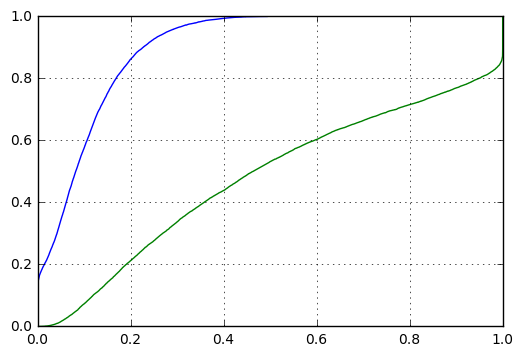

In [45]:
def ecdf(x):
    xs = np.sort(x,axis=0)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys
xe,ye = ecdf(preds_hi)
plt.plot(xe,ye)
plt.grid()

An examination the joint PDF of the first two probability values. This shows that most first predictions are greater than 90% weight, with the second prediction at < 5%. However, there is also a hotspot where both are close to 10%. This is what I initally targeted for the "unknown" label, but found that I got much better results if I considered anything under 97.2% to be most likely "unknown". This makes sense - given the CDF above, with 30% of the first predictions below a probability of 97.2%, that 30% of the test set is "unknown".

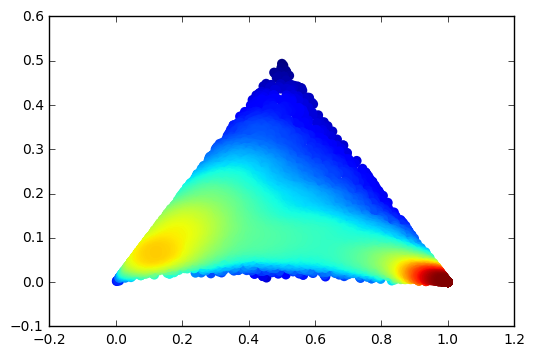

In [70]:
# plt.scatter(preds_hi,preds_hi2[:,0])
# preds_hi2[:,0].shape
# preds_hi[:,0].shape
from scipy.stats import gaussian_kde

# # Calculate the point density
xy = np.vstack([preds_hi[:,0],preds_hi2[:,0]])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
# xd, yd, zd = x[idx], y[idx], z[idx]
xd, yd, zd = preds_hi[idx,0],preds_hi2[idx,0],z[idx]
fig, ax = plt.subplots()
ax.scatter(xd, yd, c=np.log(1+zd), s=50, edgecolor='')
plt.show()
# plt.colormaps()


## Create CSV for submission
Sort by softmax norm of prediciton:

In [21]:
preds_class = np.argsort(preds_test,axis=1)

In [24]:
preds_class[0,-5:]
preds_test[0,-5:]
classes_val[2102]

'w_7e4d894'

In [23]:
classes_val = sorted(val_batch.class_indices, key=val_batch.class_indices.get)
classes_val.append('new_whale')
len(classes_val)

4251

This is the hack for introducing the 'unknown'/'new whale' category. Through empricial tests of the test set with Kaggle scoring, I found that for any entry where the greatest prediciton probability is less than 97.2%, it was best to set the first entry to "unknown". If the confidence was greater than that, set the second entry to "unknown".
This was surprising to me - it shows there are a lot of "unknown" whale in the test set.

In [25]:
li=[]
for kk in range(preds_test.shape[0]):
    
    a1=preds_class[kk,::-1][0:5]
            
    # currently best
    if preds_test_sort[kk,-1:] < 0.97: # best is .972
        a1[1:4]=a1[0:3]
        a1[0] = len(classes_val)-1
    else:
        a1[2:4]=a1[1:3]
        a1[1] = len(classes_val)-1

    li.append([classes_val[ii]+' ' for ii in a1])   

In [36]:
# newFlag = False
li[0][0:]

['w_3eaef21 ', 'w_f3d98bc ', 'w_5f6fb4e ', 'w_c20f21c ', 'w_302c025 ']

In [36]:
preds_class.shape
kk
np.shape(li)
a1

array([4250, 1844, 3588, 1113, 3913])

Build ID strings in appropriate order

In [31]:
# items[3:6] = [''.join(items[3:6])]
for kk in range(preds_test.shape[0]):
    li[kk][0:5] = [''.join(li[kk][0:5])]
li[0:5]

[['w_3eaef21 w_f3d98bc w_5f6fb4e w_c20f21c w_302c025 '],
 ['w_ffdab7a w_43be268 w_1772ed2 w_44cccf6 w_286ec5f '],
 ['w_ffdab7a w_9ea2cc3 w_b7d5069 w_5f43cde w_6710cf8 '],
 ['w_511c464 w_ffdab7a w_b8ea509 w_bbd9409 w_2c46a73 '],
 ['w_ffdab7a w_bc62c0e w_67de30b w_c9ba30c w_d3ed80e ']]

In [27]:
# items[3:6] = [''.join(items[3:6])]
for kk in range(preds_test.shape[0]):
    li[kk][0:5] = [''.join(li[kk][0:5])]
li[0:5]

[['new_whale w_7e4d894 w_7875b79 w_1127c35 w_f0af1f8 '],
 ['new_whale w_0b775c1 w_44cccf6 w_d88328d w_2901dbf '],
 ['new_whale w_9875c12 w_6c803bf w_0308405 w_1ed4dde '],
 ['new_whale w_613723e w_a2a1378 w_74e15fc w_8b6fd36 '],
 ['new_whale w_e8bce8a w_7285eb3 w_c263d43 w_e613f12 ']]

In [28]:
filenames = batches_test.filenames
ids = np.array([(f[5:]) for f in filenames])

In [29]:
import pandas as pd
submission = pd.DataFrame(li)
submission.insert(0, 'Image', [ii for ii in ids])
# submission.rename
# >>> df.rename(index=str, columns={"A": "a", "B": "c"})
submission.tail()

,Image,0
15605,fff31d26.jpg,w_6d4dedc new_whale w_a29719a w_8643ba3 w_31a9...
15606,fff3d049.jpg,new_whale w_f8c9150 w_6132293 w_18bd7b3 w_0acc...
15607,fffa5100.jpg,new_whale w_02cf46c w_ea2385d w_9ec358c w_0f96...
15608,fffa6215.jpg,new_whale w_56bbc91 w_c708776 w_e54feba w_9ec3...
15609,ffffdd7f.jpg,new_whale w_fd1cb9d w_3fdab94 w_d8eae88 w_f9fb...


In [30]:
submission.to_csv(path+'models/jrg_subm0_788_feb6_4_970.csv', index=False, compression='gzip')

In [31]:
FileLink(path+'models/jrg_subm0_788_feb6_4_970.csv')

/home/james/Documents/kaggle/whales/data/models/jrg_subm0_788_feb6_4_970.csv